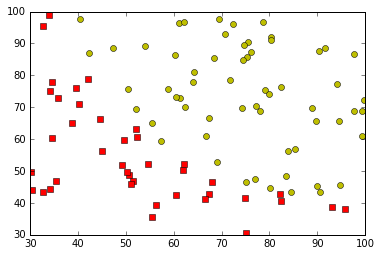

In [158]:
"""
This is a re-implementation of the material in exercise 2 of Andrew Ng's 
Coursera Machine Learning class. 
"""
%matplotlib inline
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from scipy.optimize import minimize


data = np.loadtxt('ex2data1.txt', delimiter=',')
X_initial = data[:, 0:2]
y = data[:, 2].T

positive = data[data[:, 2] == 1, :]
plt.plot(positive[:, 0], positive[:, 1], 'yo')
negative = data[data[:, 2] == 0, :]
plt.plot(negative[:, 0], negative[:, 1], 'rs')

X_initial = np.matrix(X_initial)
y = np.matrix(y).T

In [159]:
def sigmoid(z):
    return 1/(1 + np.power(math.e, -z))

h = lambda theta, x: sigmoid(x.dot(theta))
log = np.log
def cost(theta, X, y):
    m, _ = np.shape(X)
    j = y.T.dot(log(h(theta, X)))  + (1 - y).T.dot(log(1 - h(theta, X)))
    return (-j/m)[0, 0]

m, features = np.shape(X_initial)
features += 1
X = np.concatenate([np.ones((m, 1)), X_initial], axis=1)
initial_theta = np.matrix(np.zeros((features, 1)))
cost(initial_theta, X, y)

0.69314718055994529

In [160]:
def curried_cost(theta):
    theta = np.matrix(theta)
    theta = np.reshape(theta, (3, 1))
    return cost(theta, X, y)

def grad(theta, X, y):
    m, cols = np.shape(X)
    theta = np.matrix(theta)
    r, c = theta.shape
    if r < c:
        theta = theta.T
    return ((h(theta, X) - y).T.dot(X))/m

def curried_grad(theta):
    return grad(theta, X, y)

optimized_theta = minimize(curried_cost, initial_theta, jac=curried_grad)

ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [ ]:
# Test case from https://www.coursera.org/learn/machine-learning/discussions/weeks/3/threads/tA3ESpq0EeW70BJZtLVfGQ

test_X = np.matrix([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])
test_y = np.matrix([[1, 0, 1]]).T
test_theta = np.matrix([-2, -1, 1, 2,]).T

print grad(test_theta, test_X, test_y)
print cost(test_theta, test_X, test_y)
print np.shape(grad(test_theta, test_X, test_y))